# Single Image Haze Removal

### Victor Daniel Alvarado Estrella

*Paper:* http://kaiminghe.com/publications/cvpr09.pdf

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
img = cv2.imread('Example.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

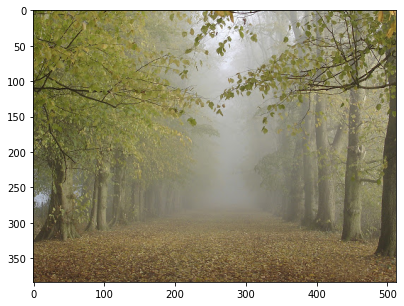

In [3]:
plt.figure(figsize = (7, 5))
plt.imshow(img)
plt.show()

### 3. Dark Channel Prior

In [0]:
# Calcula el canal oscuro (eq. 5) de una imagen.
def dark_channel(img, ksize):
    height, width, _ = img.shape
    img = np.pad(img, ((ksize//2, ksize//2), (ksize//2, ksize//2), (0, 0)), 'reflect')
    dark = np.empty((height, width), dtype = np.uint8)

    for i in range(height):
        for j in range(width):
            min_in_patch = np.amin(img[i:i+ksize, j:j+ksize], axis = (0, 1))
            dark[i, j] = np.amin(min_in_patch)

    return dark

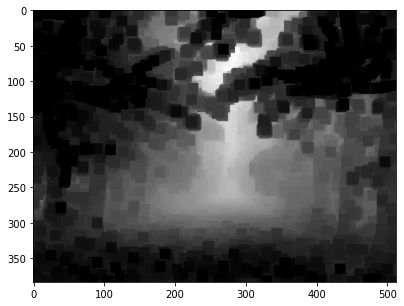

In [5]:
# Canal oscuro para la imagen de ejemplo.
plt.figure(figsize = (7, 5))
dark = dark_channel(img, 15)
plt.imshow(dark, 'gray')
plt.show()

### 4.4. Estimating the Atmospheric Light

In [0]:
# Calcula la luz atmosférica (sección 4.4) de una imagen.
def atmospheric_light(img, dark):
    height, width, channels = img.shape

    # Tomamos el 0.1% de pixeles más brillantes en el canal oscuro.
    indices = [(i, j) for i in range(height) for j in range(width)]
    indices.sort(key = lambda x: dark[x], reverse = True)
    indices = indices[:len(indices)//1000]

    # De estos pixeles, tomamos el más brillante en la imagen.
    A = np.empty(channels, dtype = np.uint8)
    for c in range(channels):
        A[c] = np.amax([img[i, j, c] for i, j in indices])

    return A

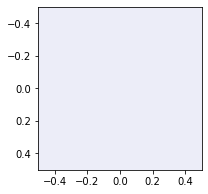

In [7]:
# Luz atmosférica para la imagen de ejemplo.
plt.figure(figsize = (3, 3))
A = atmospheric_light(img, dark)
single_color = np.reshape(A, (1, 1, 3))
plt.imshow(single_color)
plt.show()

### 4.1 Estimating the Transmission

In [0]:
# Calcula el medio de transmisión (eq. 12) de una imagen.
def medium_transmission(img, A, omega, ksize):
    height, width, _ = img.shape
    img = np.pad(img, ((ksize//2, ksize//2), (ksize//2, ksize//2), (0, 0)), 'reflect')
    t = np.empty((height, width), dtype = np.float64)

    for i in range(height):
        for j in range(width):
            min_in_patch = np.amin(img[i:i+ksize, j:j+ksize], axis = (0, 1))
            t[i, j] = 1 - omega*np.amin(min_in_patch / A)

    return t

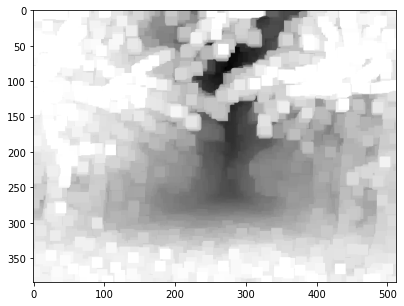

In [9]:
# Transmisión para la imagen de ejemplo.
plt.figure(figsize = (7, 5))
t = medium_transmission(img, A, 0.95, 15)
plt.imshow(t, 'gray')
plt.show()

### 4.2 Soft Matting

In [0]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

In [0]:
# Calcula la matriz L (eq. 14).
def matting_laplacian(img, ksize, epsilon):
    height, width, channels = img.shape
    patch_area = ksize*ksize
    U = epsilon/patch_area * np.identity(channels)
    
    # Datos de la matriz L.
    row = []
    col = []
    val = []

    # Para cada ventana en la imagen.
    for i in range(height - ksize):
        for j in range(width - ksize):
            # Compacta la ventana para cada color.
            patch = np.reshape(img[i:i+ksize, j:j+ksize], (-1, channels))

            # Media y covarianza por colores de la ventana.
            mean = np.mean(patch, axis = 0)
            cov = np.cov(patch, rowvar = False, bias = True)
            cov_inv = np.linalg.inv(cov + U)

            # Para cada par de pixeles en la ventana.
            for i1 in range(i, i + ksize):
                for j1 in range(j, j + ksize):
                    for i2 in range(i, i + ksize):
                        for j2 in range(j, j + ksize):
                            # Calcula la entrada correspondiente de L.
                            delta = int((i1, j1) == (i2, j2))
                            prod = (img[i1, j1] - mean).dot(cov_inv).dot(img[i2, j2] - mean)
                            
                            row.append(i1*width + j1)
                            col.append(i2*width + j2)
                            val.append(delta - (1 + prod)/patch_area)
    
    L = sparse.csr_matrix((val, (row, col)), (height*width, height*width))
    return L

In [0]:
# Calcula la transmisión óptima (eq. 15) de una imagen.
def soft_matting(L, t, lmbda):
    U = sparse.identity(L.shape[0], format = 'csr')
    t_optim = spsolve(L + lmbda*U, lmbda*t.flatten())
    t_optim = np.reshape(t_optim, t.shape)
    return t_optim

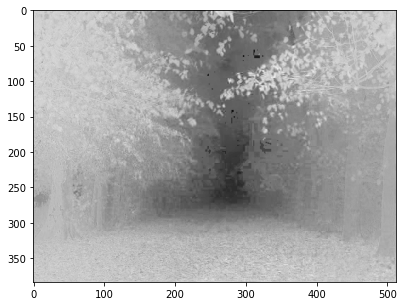

In [13]:
# Transmisión óptima para la imagen de ejemplo.
plt.figure(figsize = (7, 5))
L = matting_laplacian(img, 3, 1e-6)
t_optim = soft_matting(L, t, 1e-4)
plt.imshow(t_optim, 'gray')
plt.show()

### 4.3. Recovering the Scene Radiance

In [0]:
# Calcula la radiancia de la escena (eq. 16) de una imagen.
def scene_radiance(img, t, t0, A):
    height, width, _ = img.shape
    img = img.astype(np.float64)
    J = np.empty(img.shape, dtype = np.uint8)
    
    for i in range(height):
        for j in range(width):
            J[i, j] = (img[i, j] - A) / max(t[i, j], t0) + A

    return J

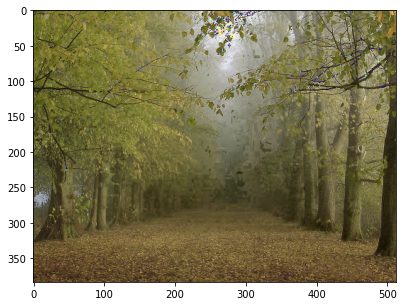

In [15]:
# Resultado final para la imagen de ejemplo.
plt.figure(figsize = (7, 5))
J = scene_radiance(img, t_optim, 0.1, A)
plt.imshow(J)
plt.show()

### Pruebas

In [0]:
# Elimina la niebla de una imagen.
def dehaze(img, ksize = 15, omega = 0.95, epsilon = 1e-6, lmbda = 1e-4, t0 = 0.1):
    dark = dark_channel(img, ksize)
    A = atmospheric_light(img, dark)

    t = medium_transmission(img, A, omega, ksize)
    L = matting_laplacian(img, 3, epsilon)
    t_optim = soft_matting(L, t, lmbda)

    J = scene_radiance(img, t_optim, t0, A)
    return J, dark, t_optim, A

In [0]:
# Prueba 1.
img1 = cv2.imread('Image1.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

In [0]:
J1, dark1, t1, A1 = dehaze(img1)

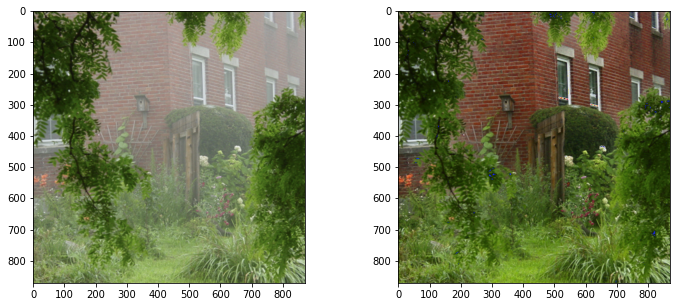

In [19]:
plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(J1)
plt.show()

In [0]:
# Prueba 2.
img2 = cv2.imread('Image2.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [0]:
J2, dark2, t2, A2 = dehaze(img2)

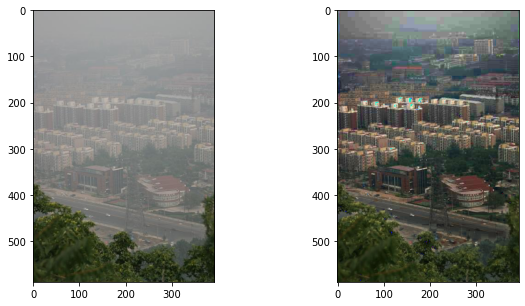

In [22]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.imshow(img2)
plt.subplot(122)
plt.imshow(J2)
plt.show()